# BAOAB method in Julia

In [1]:
using LaTeXStrings, Random, Plots, Serialization, StatsBase, Base.Threads, LinearAlgebra, Distributions, PlotUtils

function A_step(qp, h)
    q, p = qp
    q = q + h * p
    return [q, p]
end

function B_step(qp, h, force)
    q, p = qp
    F = force
    p = p + h * F
    return [q, p]
end

function O_step(qp, h, A, beta)
    q, p = qp
    alpha = exp(-h * A)
    R = randn(length(q))
    p = alpha * p + sqrt(1 / beta) * sqrt(1 - exp(-2 * h * A)) * R
    return [q, p]
end

function BAOAB_step(q, p, h, A, beta, force)
    qp = copy([q, p])
    qp = B_step(qp, h/2, force)
    qp = A_step(qp, h/2)
    qp = O_step(qp, h, A, beta)
    qp = A_step(qp, h/2)
    qp = B_step(qp, h/2, force)
    q, p = qp
    return q, p
end

BAOAB_step (generic function with 1 method)

In [2]:
function grad_BLR(data, w, N, n)
    # 2nd model - Large Scale Bayesian Logistic Regression
    dim = size(data, 2) - 1
    x = data[:, 1:dim]
    y = data[:, end]

    sum = zeros(dim)
    for i in 1:n
        a = exp(- y[i] * dot(w, x[i, :]))
        sum = sum .+ ((-y[i] * a  / (1 + a)) .* x[i, :])
    end

    w += sum .* N/n

    return w
end

function run_simulation(q0, p0, Nsteps, h, A, beta, Samples, step_function, grad_U, N, n)
    dim = size(Samples, 2) - 1
    q_traj = zeros(dim,Nsteps)
    p_traj = zeros(dim,Nsteps)
    t_traj = zeros(Nsteps)

    q = copy(q0)
    p = copy(p0)
    t = 0.0

    for i in 1:Nsteps
        idx = randperm(N)[1:n]
        data = Samples[idx,:]
        force = - grad_U(data, q, N, n)
        q, p = step_function(q, p, h, A, beta, force)
        t += h
        
        q_traj[:,i] = q
        p_traj[:,i] = p
        t_traj[i] = t
    end

    return q_traj, p_traj, t_traj
end

function sigmoid(z)
    return 1.0 ./ (1.0 .+ exp.(-z))
end

function predict_data(features, weights)
    # Calculate the linear combination of features and weights
    z = first(features' * weights)
    # Apply the logistic function to get the probability
    probabilities = sigmoid(z)
    # Apply threshold (0.5) for binary classification
    predictions = ifelse.(probabilities .>= 0.5, 1, -1)
    
    return predictions
end

function predict_BLR(q_mean, x_test, y_test)
    t = sum(q_mean)
    if isnan(t) || isinf(t)
        return 0
    end
    predicted_labels = zeros(size(x_test, 1))
    for i in 1:size(x_test, 1)
        predicted_labels[i] = predict_data(x_test[i,:], q_mean)
    end
    accuracy = sum(predicted_labels .== y_test) / length(y_test)
    return accuracy
end

# function RMSE_postmean_BLR(q_mean, x_test, y_test)
#     if isnan(q_mean) || isinf(q_mean)
#         return 0
#     end
# end

predict_BLR (generic function with 1 method)

In [3]:
function random_projection_matrix(rows, cols)
    matrix = zeros(Int, rows, cols)
    for i in 1:rows
        for j in 1:cols
            rand_num = rand()
            if rand_num <= 1/6
                matrix[i, j] = 1
            elseif rand_num <= 2/6
                matrix[i, j] = -1
            end
        end
    end
    matrix = matrix .* sqrt(3/cols)
    # matrix = rand(Normal(0, 1 / sqrt(rows)), rows, cols)
    return matrix 
end

function save_variable(variable, file_name)
    name = string(file_name, ".jls")
    open(name, "w") do file
        serialize(file, variable)
    end
end

save_variable (generic function with 1 method)

In [4]:
# using MLDatasets
# dim = 100
# train_x, train_y = MNIST(split=:train)[:]
# ind = findall(x -> x == 7 || x == 9, train_y)
# Random.seed!(42)
# rpm = random_projection_matrix(size(train_x, 1)*size(train_x, 2), dim)

# y_train = train_y[ind]
# y_train = ifelse.(y_train .== 7, 1, -1)
# x_train = transpose(reshape(train_x, size(train_x, 1)*size(train_x, 2), size(train_x, 3))[:, ind])
# x_train = x_train * rpm
# train = hcat(x_train, y_train)

# test_x, test_y = MNIST(split=:test)[:]
# ind = findall(x -> x == 7 || x == 9, test_y)
# y_test = test_y[ind]
# y_test = ifelse.(y_test .== 7, 1, -1)
# x_test = transpose(reshape(test_x, size(test_x, 1)*size(test_x, 2), size(test_x, 3))[:, ind]);
# x_test = x_test * rpm;

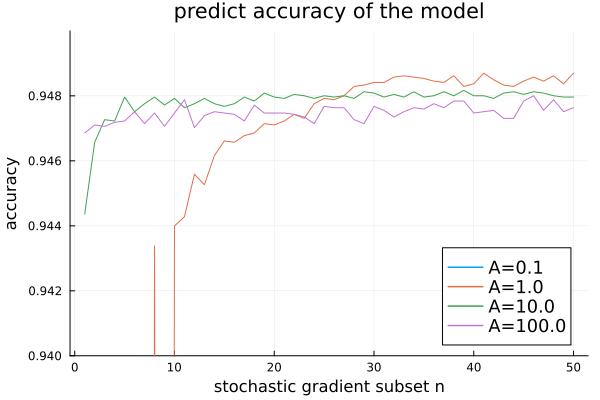

In [5]:
n_lst = 1:50
A_lst = [0.1, 1, 10, 100]
predict_matrix_perc = open(deserialize, "predict_matrix_perc.jls");
# min_nonzero = minimum(predict_matrix_perc[predict_matrix_perc .!= 0])
# predict_matrix_perc = map(x -> x == 0 ? min_nonzero : x, predict_matrix_perc)

p_ = plot()
title!("predict accuracy of the model")
for i in 1:length(A_lst)
    A = A_lst[i]
    plot!(p_, n_lst, predict_matrix_perc[i,:], label="A=$(A)")
end

xlabel!(p_, "stochastic gradient subset n")
ylabel!(p_, "accuracy")
# xaxis!(:log10)
# yaxis!(:log10)
# xticks!(collect(0:50:500))
# xlims!(0,50); xticks!(0:10:50)
ylims!(0.94, 0.95)
plot!(legendfontsize=12)

plot(p_, legend=:topright)
display(plot(p_))
# savefig("accuracy_vs_n_0to50_full.pdf")

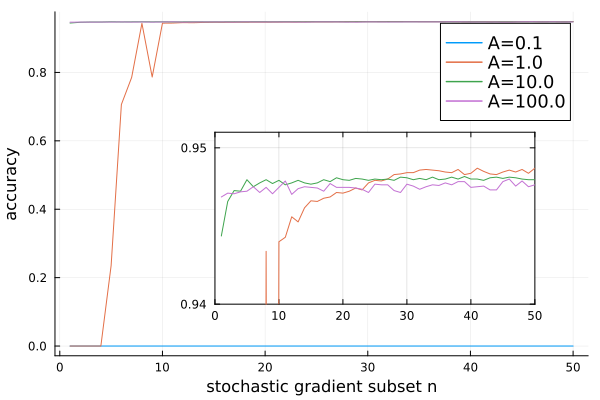

"e:\\OneDrive - University of Edinburgh\\MATH11197 Research Skills for CAM\\Group Project\\data\\Langevin Problem 2 - 2 - 0to50\\accuracy_vs_n_0to50_combine.pdf"

In [10]:
p_main = plot(
    n_lst, predict_matrix_perc', 
    label=reshape(["A=$(A)" for A in A_lst],1,4), 
    xlabel="stochastic gradient subset n", ylabel="accuracy", 
    legendfontsize=12, legend=:topright
)

p_inset = plot!(
    n_lst, predict_matrix_perc', 
    label="", 
    yticks=[0.94, 0.95], xlims=(0, 50), ylims=(0.94, 0.951),
    inset = (1, bbox(0.1, 0.15, 0.6, 0.5, :bottom, :right)), subplot = 2,
    framestyle=:box,
    xlabel="", ylabel="", legend=false
)

display(p_main)
# savefig("accuracy_vs_n_0to50_combine.pdf")